In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spam-sms-data/spam.csv


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from matplotlib import style
style.use('ggplot')
import re
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
path_data="/kaggle/input/spam-sms-data/spam.csv"

In [4]:
try:
    df = pd.read_csv(path_data, encoding='Windows-1252')
    print(df.head(10))
except UnicodeDecodeError as e:
    print(f"UnicodeDecodeError: {e}")

     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   
5  spam  FreeMsg Hey there darling it's been 3 week's n...        NaN   
6   ham  Even my brother is not like to speak with me. ...        NaN   
7   ham  As per your request 'Melle Melle (Oru Minnamin...        NaN   
8  spam  WINNER!! As a valued network customer you have...        NaN   
9  spam  Had your mobile 11 months or more? U R entitle...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  
5        NaN        NaN  
6        NaN  

In [5]:
df = df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])

In [6]:
df.shape

(5572, 2)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


Text(0.5, 1.0, 'Sms distribution')

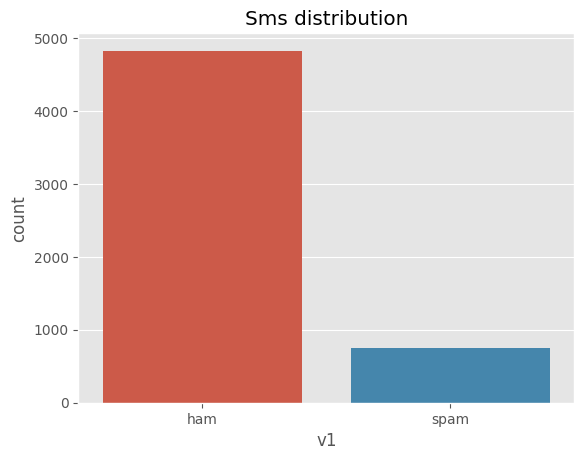

In [8]:
sns.countplot(x='v1', data=df)
plt.title("Sms distribution")

In [9]:
def data_processing(text):
    text= text.lower()
    text = re.sub('<br />', '', text)
    text = re.sub(r"https\S+|www\S+|http\S+", '', text, flags = re.MULTILINE)
    text = re.sub(r'\@w+|\#', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if not w in stop_words]
    return " ".join(filtered_text)

In [10]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
df.v2 = df['v2'].apply(data_processing)

In [12]:
duplicated_count = df.duplicated().sum()
print("Number of duplicate entries: ", duplicated_count)

Number of duplicate entries:  459


In [13]:
df = df.drop_duplicates()

In [14]:
stemmer = PorterStemmer()
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data

In [15]:
df.v2 = df['v2'].apply(lambda x: stemming(x))

In [16]:
df.v2

0       go jurong point crazy available bugis n great ...
1                                 ok lar joking wif u oni
2       free entry 2 wkly comp win fa cup final tkts 2...
3                     u dun say early hor u c already say
4             nah dont think goes usf lives around though
                              ...                        
5567    2nd time tried 2 contact u u å750 pound prize ...
5568                         ì_ b going esplanade fr home
5569                          pity mood soany suggestions
5570    guy bitching acted like id interested buying s...
5571                                       rofl true name
Name: v2, Length: 5113, dtype: object

In [17]:
df.head()

,v1,v2
0,ham,go jurong point crazy available bugis n great ...
1,ham,ok lar joking wif u oni
2,spam,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,u dun say early hor u c already say
4,ham,nah dont think goes usf lives around though


In [18]:
right_sms =  df[df.v1 == 'ham']
right_sms.head()

,v1,v2
0,ham,go jurong point crazy available bugis n great ...
1,ham,ok lar joking wif u oni
3,ham,u dun say early hor u c already say
4,ham,nah dont think goes usf lives around though
6,ham,even brother like speak treat like aids patent


In [19]:
spam_sms =  df[df.v1 == 'spam']
spam_sms.head()

,v1,v2
2,spam,free entry 2 wkly comp win fa cup final tkts 2...
5,spam,freemsg hey darling 3 weeks word back id like ...
8,spam,winner valued network customer selected receiv...
9,spam,mobile 11 months u r entitled update latest co...
11,spam,six chances win cash 100 20000 pounds txt csh1...


In [20]:
X = df['v2']
Y = df['v1']

In [21]:
vect = TfidfVectorizer()
X = vect.fit_transform(df['v2'])

In [22]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [23]:
print("Size of x_train: ", (x_train.shape))
print("Size of y_train: ", (y_train.shape))
print("Size of x_test: ", (x_test.shape))
print("Size of y_test: ", (y_test.shape))

Size of x_train:  (4090, 9336)
Size of y_train:  (4090,)
Size of x_test:  (1023, 9336)
Size of y_test:  (1023,)


In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [25]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
logreg_pred = logreg.predict(x_test)
logreg_acc = accuracy_score(logreg_pred, y_test)
print("Training accuracy Score    : ",logreg.score(x_train,y_train))
print("Test accuracy Score : ",logreg_acc )
print(classification_report(y_test, logreg_pred))

Training accuracy Score    :  0.9577017114914426
Test accuracy Score :  0.9384164222873901
              precision    recall  f1-score   support

         ham       0.94      1.00      0.97       888
        spam       0.96      0.56      0.70       135

    accuracy                           0.94      1023
   macro avg       0.95      0.78      0.83      1023
weighted avg       0.94      0.94      0.93      1023



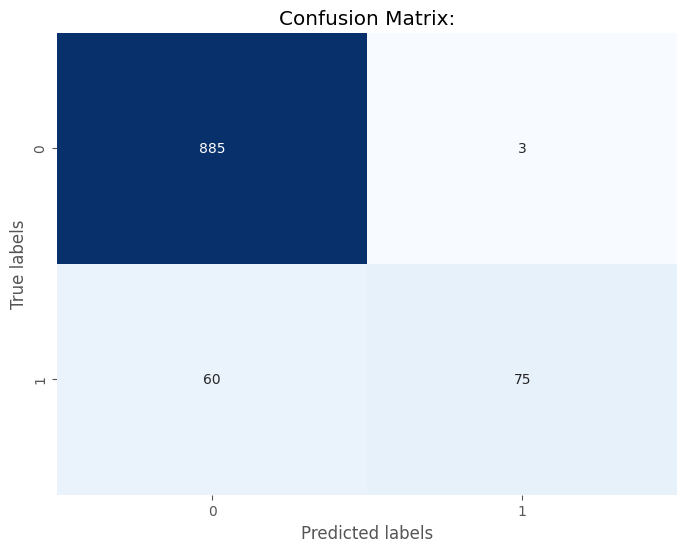

In [26]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, logreg_pred)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix:")
plt.show()

In [27]:
mnb = MultinomialNB()
mnb.fit(x_train, y_train)
mnb_pred = mnb.predict(x_test)
mnb_acc = accuracy_score(mnb_pred, y_test)
print("Training accuracy Score    : ",mnb.score(x_train,y_train))
print("Test accuracy Score : ",mnb_acc )
print(classification_report(mnb_pred,y_test))

Training accuracy Score    :  0.9682151589242054
Test accuracy Score :  0.956989247311828
              precision    recall  f1-score   support

         ham       1.00      0.95      0.98       932
        spam       0.67      1.00      0.81        91

    accuracy                           0.96      1023
   macro avg       0.84      0.98      0.89      1023
weighted avg       0.97      0.96      0.96      1023



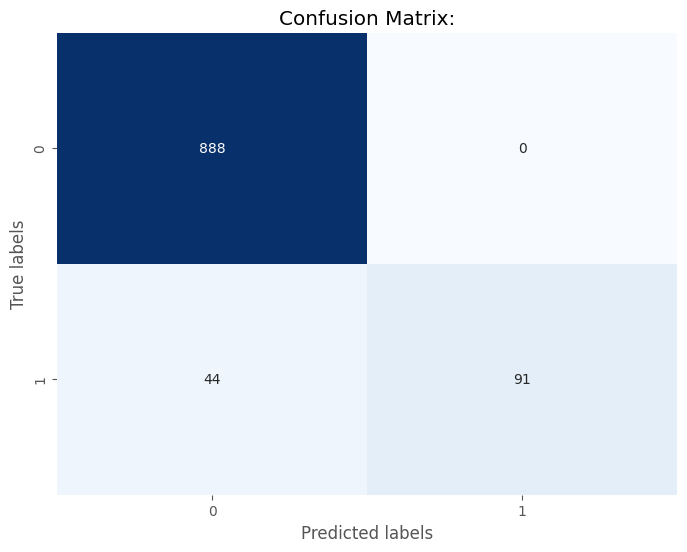

In [28]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, mnb_pred)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix:")
plt.show()

In [29]:
svc = LinearSVC()
svc.fit(x_train, y_train)
svc_pred = svc.predict(x_test)
svc_acc = accuracy_score(svc_pred, y_test)
print("Training accuracy Score    : ",svc.score(x_train,y_train))
print("Test accuracy Score : ",svc_acc )
print(classification_report(svc_pred,y_test))

Training accuracy Score    :  0.9995110024449878
Test accuracy Score :  0.9775171065493646
              precision    recall  f1-score   support

         ham       0.99      0.98      0.99       901
        spam       0.87      0.96      0.91       122

    accuracy                           0.98      1023
   macro avg       0.93      0.97      0.95      1023
weighted avg       0.98      0.98      0.98      1023



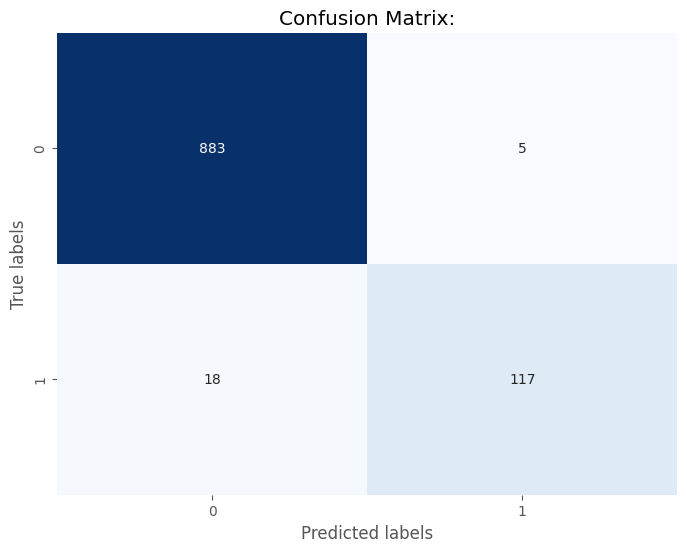

In [30]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, svc_pred)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix:")
plt.show()

In [32]:
models = pd.DataFrame({
    'Model': ['Logistic Regression',
              'Naive Bayes',
              'Support Vector'],
    'Test accuracy': [logreg_acc,
              mnb_acc,
              svc_acc]})

models.sort_values(by='Test accuracy', ascending=False)

,Model,Test accuracy
2,Support Vector,0.977517
1,Naive Bayes,0.956989
0,Logistic Regression,0.938416
